In [1]:
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# 14.2 합성곱 층

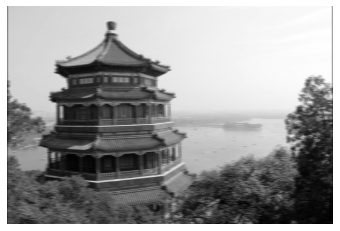

In [3]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0] = 1
filters[3,:,:,1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")
plt.imshow(outputs[0,:,:,1], cmap="gray")
plt.axis("off")
plt.show()

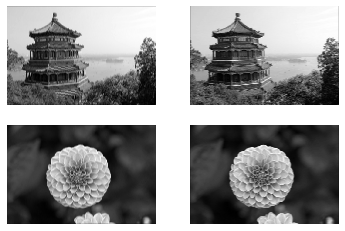

In [4]:
for image_index in (0,1):
    for feature_map_index in (0,1):
        plt.subplot(2,2,image_index * 2 + feature_map_index+1)
        plot_image(outputs[image_index,:,:,feature_map_index])
plt.show()

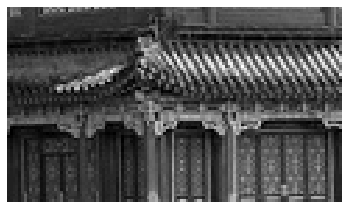

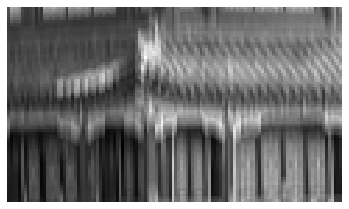

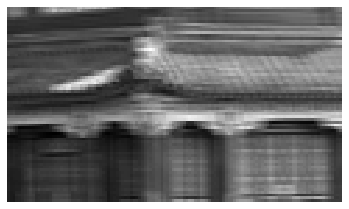

In [5]:
def crop(images):
    return images[150:220, 130:250]

plot_image(crop(images[0,:,:,0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    plt.show()

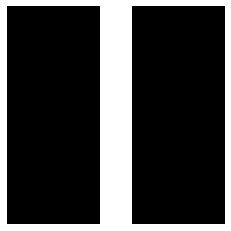

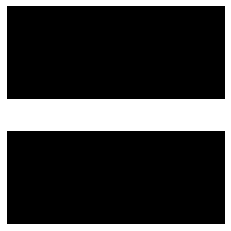

In [6]:
plot_image(filters[:,:,0,0])
plt.show()
plot_image(filters[:,:,0,1])
plt.show()

### Convolution Layer

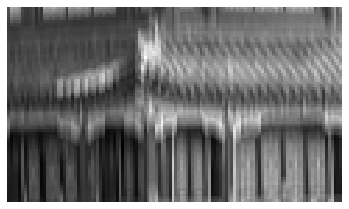

In [7]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

plot_image(crop(outputs[0,:,:,0]))
plt.show()

### VALID vs SAME padding

In [8]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
    if padding=="SAME":
        return (input_size - 1) // strides+1
    else:
        return (input_size - kernel_size) // strides+1

In [9]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [10]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)

    
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_image = np.zeros(padded_shape, dtype=np.float32)
    padded_image[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_image




In [11]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size,strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images,kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))

conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())


# 14.3 풀링 층


## Max pooling

In [12]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [13]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

Saving figure china_max_pooling


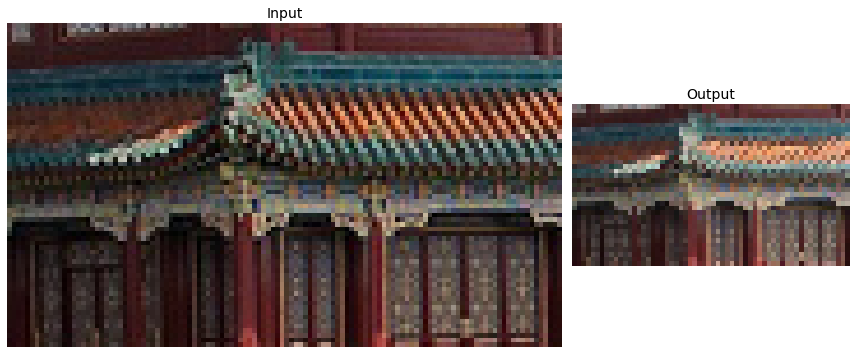

In [14]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## depth-wise pooling

In [15]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding

    def call(self, inputs):
        return tf.nn.max_pool(inputs, ksize=(1,1,1,self.pool_size), strides=(1,1,1,self.pool_size), padding=self.padding)

In [16]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [17]:
depth_pool = keras.layers.Lambda(lambda X : tf.nn.max_pool(
    X, ksize=(1,1,1,3), strides=(1,1,1,3), padding="VALID"
))

with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)
depth_output.shape


TensorShape([2, 70, 120, 1])

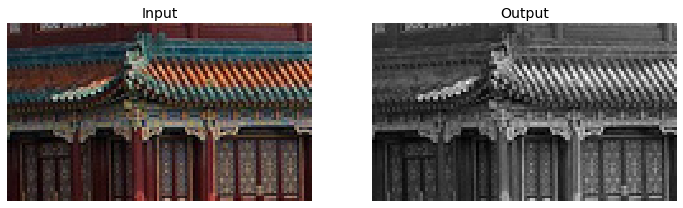

In [18]:

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average Pooling

In [19]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

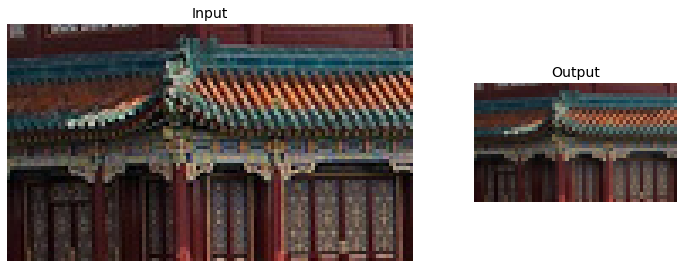

In [20]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling


In [21]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [22]:
output_global_avg2 = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis=[1,2]))
output_global_avg2(cropped_images)




<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

# 14.4 CNN 구조

In [23]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [24]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [25]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.6958 - accuracy: 0.7561 - val_loss: 0.3858 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4156 - accuracy: 0.8609 - val_loss: 0.3434 - val_accuracy: 0.8756
Epoch 3/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3601 - accuracy: 0.8797 - val_loss: 0.3077 - val_accuracy: 0.8944
Epoch 4/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3270 - accuracy: 0.8919 - val_loss: 0.2896 - val_accuracy: 0.8926
Epoch 5/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3018 - accuracy: 0.8976 - val_loss: 0.2772 - val_accuracy: 0.9000
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2864 - accuracy: 0.9035 - val_loss: 0.2904 - val_accuracy: 0.8934
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2717 - accuracy: 0.9072 - val_loss: 0.2992 - val_ac

In [26]:
import tensorflow as tf

print(tf.__version__)
# 1.14.0

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 14.5 케라스를 이용해 ResNet-34 CNN 구현

In [27]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

# 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [30]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")
images_resized = tf.image.resize(images, [224,224])
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)


In [31]:
Y_proba = model.predict(inputs)

In [32]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

Image #1
  n03530642 - honeycomb    49.83%
  n13040303 - stinkhorn    33.95%
  n02206856 - bee          4.35%



# 14.7 사전훈련된 모델을 사용한 전이학습

In [33]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [34]:
test_set, valid_set, train_set = tfds.load("tf_flowers",split=["train[:10%]", "train[10%:25%]", "train[25%:]"],as_supervised=True)

In [35]:
def preprocess(image, label):
    resized_image = tf.image.resize(image,[224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [36]:
batch_size=32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [37]:
n_classes = info.features["label"].num_classes

In [38]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [39]:
for layer in base_model.layers:
    layer.trainable = False

In [40]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 9s 110ms/step - loss: 1.3551 - accuracy: 0.7918 - val_loss: 1.4193 - val_accuracy: 0.8185
Epoch 2/5
86/86 [==============================] - 9s 101ms/step - loss: 0.5270 - accuracy: 0.9008 - val_loss: 0.7128 - val_accuracy: 0.8784
Epoch 3/5
86/86 [==============================] - 9s 103ms/step - loss: 0.2422 - accuracy: 0.9368 - val_loss: 0.6905 - val_accuracy: 0.8802
Epoch 4/5
86/86 [==============================] - 9s 100ms/step - loss: 0.0978 - accuracy: 0.9673 - val_loss: 0.6796 - val_accuracy: 0.8621
Epoch 5/5
86/86 [==============================] - 8s 98ms/step - loss: 0.0679 - accuracy: 0.9778 - val_loss: 0.6338 - val_accuracy: 0.8748


In [41]:

dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [42]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 35s 408ms/step - loss: 0.3301 - accuracy: 0.8953 - val_loss: 0.9595 - val_accuracy: 0.8125
Epoch 2/5
86/86 [==============================] - 35s 403ms/step - loss: 0.0677 - accuracy: 0.9793 - val_loss: 0.4172 - val_accuracy: 0.9099
Epoch 3/5
86/86 [==============================] - 34s 399ms/step - loss: 0.0364 - accuracy: 0.9895 - val_loss: 0.2697 - val_accuracy: 0.9301
Epoch 4/5
86/86 [==============================] - 35s 401ms/step - loss: 0.0234 - accuracy: 0.9942 - val_loss: 0.2660 - val_accuracy: 0.9301
Epoch 5/5
86/86 [==============================] - 36s 419ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.3230 - val_accuracy: 0.9301


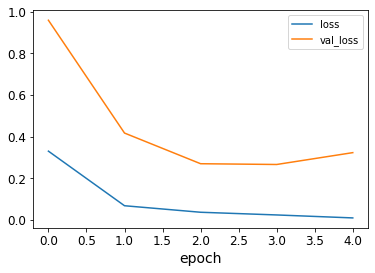

In [43]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("epoch")
plt.legend(["loss","val_loss"])

# 14.8 분류와 위치 추정

- 물체 중심의 수평, 수직좌표와 높이,너비를 예측

In [45]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes,activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.Model(inputs=base_model.input, outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"], loss_weights=[0.0,0.2], optimizer=optimizer, metrics=["accuracy"])

In [46]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0],4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [47]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 2s 381ms/step - loss: 0.0680 - dense_5_loss: 1.6683 - dense_6_loss: 0.3398 - dense_5_accuracy: 0.2125 - dense_6_accuracy: 0.3187
Epoch 2/2
5/5 [==============================] - 2s 374ms/step - loss: 0.0423 - dense_5_loss: 1.6273 - dense_6_loss: 0.2114 - dense_5_accuracy: 0.1937 - dense_6_accuracy: 0.2750


### Mean Average Precision(mAP)

In [48]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

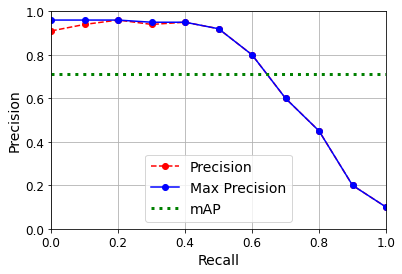

In [49]:
recalls = np.linspace(0,1,11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()